In [39]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
import keras
import tensorflow as tf
from keras import layers


import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
import time
import timeit

# Load Datasets

In [4]:
df = pd.read_csv("../datasets/Stocks/aapl.us.txt", 
                 na_values=['null'], 
                 index_col=['Date'],
                 parse_dates=True,
                 infer_datetime_format=True,
                 )
df

C:\Users\Hammam\AppData\Local\Temp\ipykernel_16224\32775085.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("../datasets/Stocks/aapl.us.txt",


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0
...,...,...,...,...,...,...
2017-11-06,171.75000,174.36000,171.10000,173.63000,34901241,0
2017-11-07,173.29000,174.51000,173.29000,174.18000,24424877,0
2017-11-08,174.03000,175.61000,173.71000,175.61000,24451166,0


# Data Preprocessing

In [5]:
print("Dataframe Shape: ", df.shape)
print("Null Value Present: ", df.isnull().values.any())

Dataframe Shape:  (8364, 6)
Null Value Present:  False


<Axes: xlabel='Date'>

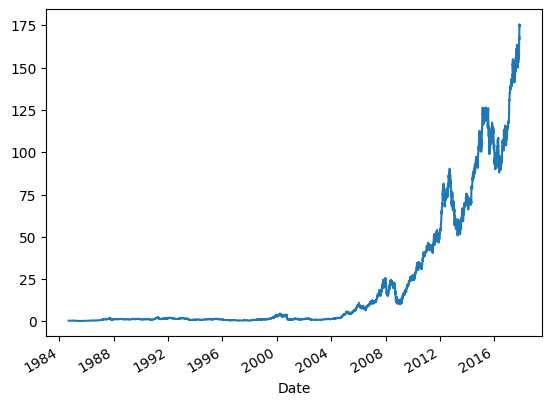

In [6]:
df['Close'].plot()

In [7]:
output_var = pd.DataFrame(df['Close'])
features = ['Open', 'High', 'Low', 'Volume',]

In [10]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

c:\Users\Hammam\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Hammam\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Hammam\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Hammam\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and a

,Open,High,Low,Volume
Date,,,,
1984-09-07,0.001091,0.001103,0.001082,0.011219
1984-09-10,0.001091,0.001081,0.001052,0.008708
1984-09-11,0.001099,0.001146,0.001118,0.020533
1984-09-12,0.001121,0.001117,0.001067,0.017937
1984-09-13,0.001179,0.001168,0.001199,0.027936


In [11]:
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index) : (len(train_index) + len(test_index))]
    y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index) : (len(train_index) + len(test_index))].values.ravel()

In [12]:
trainX = np.array(X_train)
testX = np.array(X_test)

X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

# Helper Classes

In [36]:
class Evaluate:

  def __init__(self, actual, predictions) -> None:
    self.actual = actual
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

# Build Model

In [14]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0, attention_axes=None):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

In [27]:
def build_transfromer(head_size, 
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 1, 4, 1 
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs 
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs, activation='relu')(x)
  return tf.keras.Model(inputs, outputs)

In [28]:
transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, 
                                num_trans_blocks=4, mlp_units=[256], 
                                mlp_dropout=0.10, dropout=0.10, 
                                )

In [29]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, 
                                              restore_best_weights=True)]

In [37]:

def fit_transformer(transformer: tf.keras.Model):
  """
  Compiles and fits our transformer.
  """
  transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'])

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
  start = time.time()
  hist = transformer.fit(X_train, y_train, batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
  print(time.time() - start)
  return hist

In [33]:
transformer.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1, 4)]       0           []                               
                                                                                                  
 layer_normalization_16 (LayerN  (None, 1, 4)        8           ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 1, 4)        9732        ['layer_normalization_16[0][0]', 
 eadAttention)                                                    'layer_normalization_16[0][0]'] 
                                                                                            

# Train

In [40]:
hist = fit_transformer(transformer)

Epoch 1/25


238/238 [==============================] - 34s 24ms/step - loss: 26.8941 - mae: 3.4088 - mape: 150.7140
Epoch 2/25
238/238 [==============================] - 6s 24ms/step - loss: 25.7095 - mae: 3.3160 - mape: 147.5904
Epoch 3/25
238/238 [==============================] - 6s 24ms/step - loss: 25.4726 - mae: 3.3217 - mape: 147.7069
Epoch 4/25
238/238 [==============================] - 6s 26ms/step - loss: 24.9651 - mae: 3.2862 - mape: 144.8117
Epoch 5/25
238/238 [==============================] - 8s 35ms/step - loss: 25.7474 - mae: 3.3455 - mape: 147.5143
Epoch 6/25
238/238 [==============================] - 6s 23ms/step - loss: 28.6118 - mae: 3.4573 - mape: 151.4854
Epoch 7/25
238/238 [==============================] - 6s 24ms/step - loss: 24.3519 - mae: 3.2367 - mape: 143.6904
Epoch 8/25
238/238 [==============================] - 7s 28ms/step - loss: 24.9079 - mae: 3.2705 - mape: 148.9459
Epoch 9/25
238/238 [==============================] - 6s 23ms/step - loss: 24.9626 - mae: 3.2868 -

# Evaluate and Test

In [45]:
y_pred = hist.model.predict(X_test)

 1/24 [>.............................] - ETA: 2s

24/24 [==============================] - 0s 10ms/step


In [47]:
transformer_evals = Evaluate(y_test, y_pred)

In [52]:
print(transformer_evals.mape)
print(transformer_evals.var_ratio)

0.1683889326987354
0.8151371840177123


# Visualizing

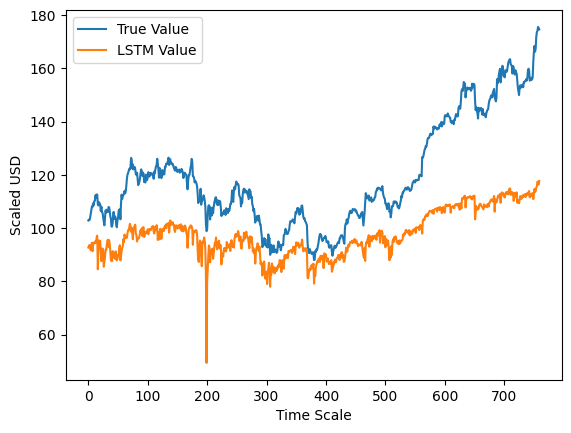

In [71]:
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()